# Data preprocessing

In [ ]:
!pip install -U datasets

In [ ]:
# Imports
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from datasets import load_dataset

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Download NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load datasets
test_df = pd.read_csv('/content/drive/MyDrive/vu_tm/sentiment-topic-test.tsv', sep='\t')
topic_train_df = pd.read_csv('/content/drive/MyDrive/vu_tm/big_data.csv')
print("Test dataset loaded successfully.")
print(test_df.head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Test dataset loaded successfully.
   sentence_id                                           sentence sentiment  \
0            0  The stadium was alive with the roar of the cro...  positive   
1            1  That last-minute goal had me jumping out of my...  positive   
2            2  I couldn’t put the book down; it swept me into...  positive   
3            3  The story had its moments, though some parts f...   neutral   
4            4  I enjoyed the way the timelines shifted, even ...   neutral   

    topic  
0  sports  
1  sports  
2    book  
3    book  
4    book  


In [ ]:
# Data preprocessing

# A. For Sentiment Analysis: using SST-1
print("\nLoading SST-1 (5-class) dataset for sentiment analysis...")
sst_dataset = load_dataset('sst')

sentiment_train_df = sst_dataset['train'].to_pandas()
sentiment_val_df = sst_dataset['validation'].to_pandas()
sentiment_train_df = pd.concat([sentiment_train_df, sentiment_val_df])

def map_float_to_3_sentiment_labels(score):
    if score <= 0.33:
        return 'negative'
    elif score <= 0.66:
        return 'neutral'
    else:
        return 'positive'

sentiment_train_df['sentiment'] = sentiment_train_df['label'].apply(map_float_to_3_sentiment_labels)
sentiment_train_df = sentiment_train_df[['sentence', 'sentiment']]

print(f"SST-1 sentiment training data size: {len(sentiment_train_df)}")
print("First 5 rows of sentiment training data with 3-class mapping:")
print(sentiment_train_df.head())

# B. For Topic Analysis: Using kaggle topic analysis dataset
if topic_train_df.columns[0].startswith('Unnamed:'):
    topic_train_df = topic_train_df.drop(columns=topic_train_df.columns[0])

# Nomralize columns
topic_train_df = topic_train_df.rename(columns={'review': 'sentence', 'label': 'topic'})
print(f"Kaggle Topic Analysis dataset loaded successfully")
print(f"Kaggle Topic Analysis dataset size: {len(topic_train_df)}")
print("First 5 rows of topic training data:")
print(topic_train_df.head())

# Preprocessing function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    try:
        text = str(text)
    except Exception as e:
        print(f"Warning: Could not convert input to string. Error: {e}. Input: {text}")
        return ''

    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    text = emoji_pattern.sub(r'', text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply
sentiment_train_df['processed_sentence'] = sentiment_train_df['sentence'].apply(preprocess_text)
topic_train_df['processed_sentence'] = topic_train_df['sentence'].fillna('').apply(preprocess_text)
test_df['processed_sentence'] = test_df['sentence'].apply(preprocess_text)

print("\nSample preprocessed sentence from test data:")
print(test_df['processed_sentence'].iloc[0])


Loading SST-1 (5-class) dataset for sentiment analysis...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.68k [00:00<?, ?B/s]

sst.py:   0%|          | 0.00/9.13k [00:00<?, ?B/s]

SST-1 sentiment training data size: 9645
First 5 rows of sentiment training data with 3-class mapping:
                                            sentence sentiment
0  The Rock is destined to be the 21st Century 's...  positive
1  The gorgeously elaborate continuation of `` Th...  positive
2  Singer\/composer Bryan Adams contributes a sle...   neutral
3  You 'd think by now America would have had eno...   neutral
4               Yet the act is still charming here .  positive
Kaggle Topic Analysis dataset loaded successfully
Kaggle Topic Analysis dataset size: 120307
First 5 rows of topic training data:
                                            sentence topic
0  I'm only a third way in. Shipped lightening fa...  book
1  "There have been so many times when I was scar...  book
2  The media could not be loaded. I personally ha...  book
3  I have been a fan of Britney's music since the...  book
4  Whether or not you’re a fan, it’s a great read...  book

Sample preprocessed sentence from 

# Data analysis
## Training dataset


--- Sentiment Training Data Analysis (SST-1) ---

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 9645 entries, 0 to 1100
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sentence            9645 non-null   object
 1   sentiment           9645 non-null   object
 2   processed_sentence  9645 non-null   object
 3   sentence_length     9645 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 376.8+ KB

Missing values (NaNs) per column:
sentence              0
sentiment             0
processed_sentence    0
sentence_length       0
dtype: int64

Unique Sentiment Classes:
['positive' 'neutral' 'negative']

Sentiment Class Distribution:
sentiment
positive    3488
neutral     3223
negative    2934
Name: count, dtype: int64


<ipython-input-6-8833e7116197>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


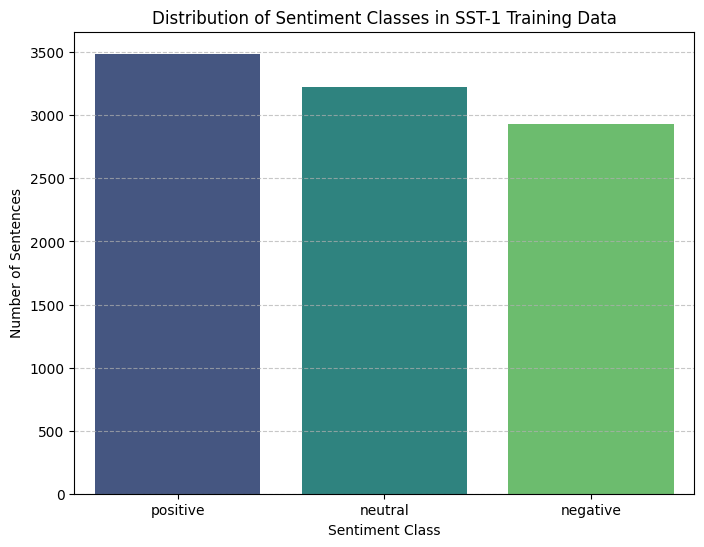


Sentiment Sentence Length Statistics:
count    9645.000000
mean      102.410886
std        51.120796
min         4.000000
25%        63.000000
50%        98.000000
75%       137.000000
max       267.000000
Name: sentence_length, dtype: float64


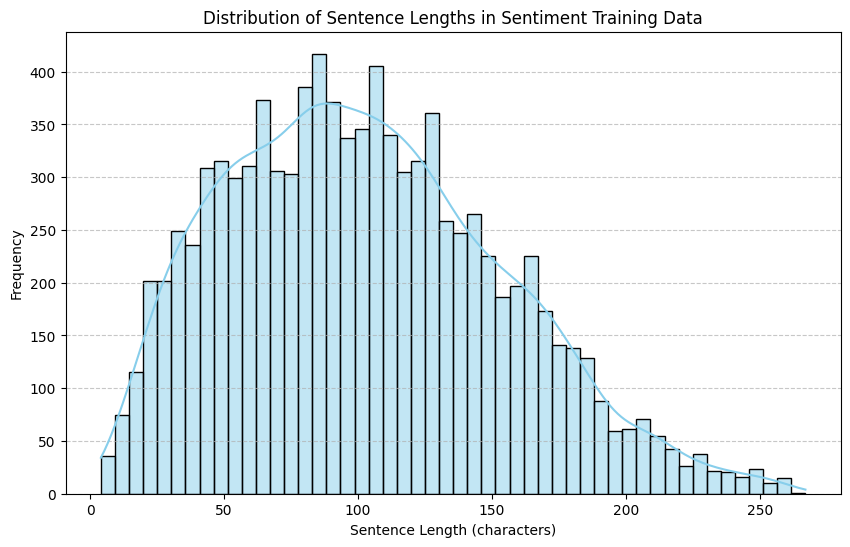


--- Topic Training Data Analysis (Kaggle) ---

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120307 entries, 0 to 120306
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   sentence            120305 non-null  object
 1   topic               120307 non-null  object
 2   processed_sentence  120307 non-null  object
dtypes: object(3)
memory usage: 2.8+ MB

Missing values (NaNs) per column:
sentence              2
topic                 0
processed_sentence    0
dtype: int64

Unique Topic Classes:
['book' 'movie' 'sports']

Topic Class Distribution:
topic
movie     50000
sports    36726
book      33581
Name: count, dtype: int64


<ipython-input-6-8833e7116197>:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='magma')


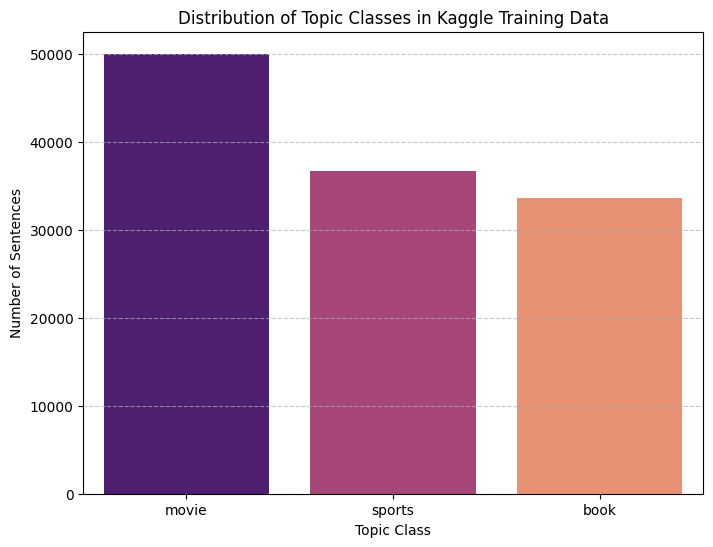


Topic Sentence Length Statistics:
count    120307.000000
mean        750.998387
std         935.114653
min           1.000000
25%         170.000000
50%         394.000000
75%         970.000000
max       29952.000000
Name: sentence_length, dtype: float64


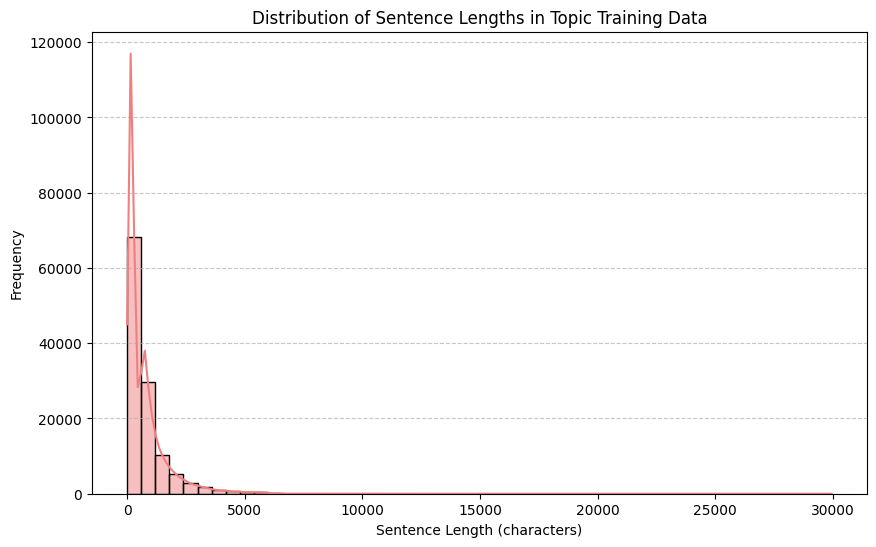

In [ ]:
# Data analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment training dataset
print("\n" + "="*50)
print("--- Sentiment Training Data Analysis (SST-1) ---")
print("="*50)

print("\nDataFrame Info:")
sentiment_train_df.info()

print("\nMissing values (NaNs) per column:")
print(sentiment_train_df.isnull().sum())

print("\nUnique Sentiment Classes:")
print(sentiment_train_df['sentiment'].unique())

print("\nSentiment Class Distribution:")
sentiment_counts = sentiment_train_df['sentiment'].value_counts()
print(sentiment_counts)

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Distribution of Sentiment Classes in SST-1 Training Data')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Sentences')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

sentiment_train_df['sentence_length'] = sentiment_train_df['sentence'].apply(len)
print("\nSentiment Sentence Length Statistics:")
print(sentiment_train_df['sentence_length'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(sentiment_train_df['sentence_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Sentence Lengths in Sentiment Training Data')
plt.xlabel('Sentence Length (characters)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Topic training dataset
print("\n" + "="*50)
print("--- Topic Training Data Analysis (Kaggle) ---")
print("="*50)

print("\nDataFrame Info:")
topic_train_df.info()

print("\nMissing values (NaNs) per column:")
print(topic_train_df.isnull().sum())

print("\nUnique Topic Classes:")
print(topic_train_df['topic'].unique())

print("\nTopic Class Distribution:")
topic_counts = topic_train_df['topic'].value_counts()
print(topic_counts)

plt.figure(figsize=(8, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='magma')
plt.title('Distribution of Topic Classes in Kaggle Training Data')
plt.xlabel('Topic Class')
plt.ylabel('Number of Sentences')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

topic_train_df['sentence_length'] = topic_train_df['sentence'].astype(str).apply(len)
print("\nTopic Sentence Length Statistics:")
print(topic_train_df['sentence_length'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(topic_train_df['sentence_length'], bins=50, kde=True, color='lightcoral')
plt.title('Distribution of Sentence Lengths in Topic Training Data')
plt.xlabel('Sentence Length (characters)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Remove 'sentence_length'
sentiment_train_df = sentiment_train_df.drop(columns=['sentence_length'])
topic_train_df = topic_train_df.drop(columns=['sentence_length'])

## Test dataset


--- Test Dataset Analysis ---

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sentence_id         18 non-null     int64 
 1   sentence            18 non-null     object
 2   sentiment           18 non-null     object
 3   topic               18 non-null     object
 4   processed_sentence  18 non-null     object
dtypes: int64(1), object(4)
memory usage: 852.0+ bytes

Missing values (NaNs) per column:
sentence_id           0
sentence              0
sentiment             0
topic                 0
processed_sentence    0
dtype: int64

Unique Sentiment Classes in Test Data:
['positive' 'neutral' 'negative']

Sentiment Class Distribution in Test Data:
sentiment
positive    6
neutral     6
negative    6
Name: count, dtype: int64


<ipython-input-7-3464b5da028d>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_sentiment_counts.index, y=test_sentiment_counts.values, palette='viridis')


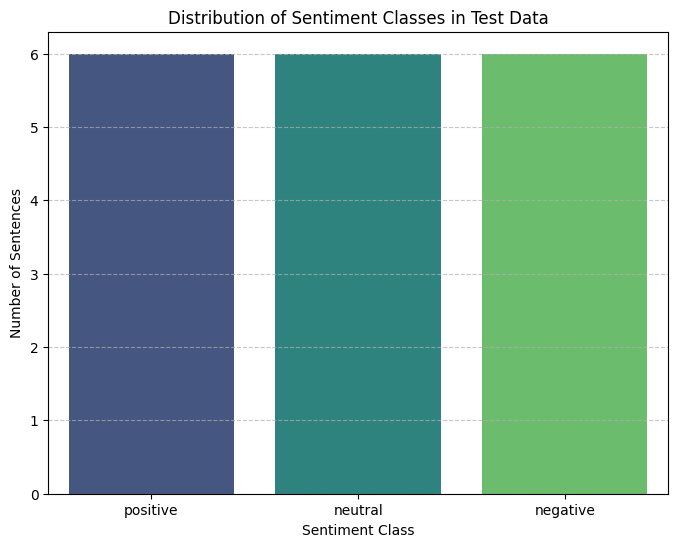


Unique Topic Classes in Test Data:
['sports' 'book' 'movie']

Topic Class Distribution in Test Data:
topic
sports    6
book      6
movie     6
Name: count, dtype: int64


<ipython-input-7-3464b5da028d>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_topic_counts.index, y=test_topic_counts.values, palette='magma')


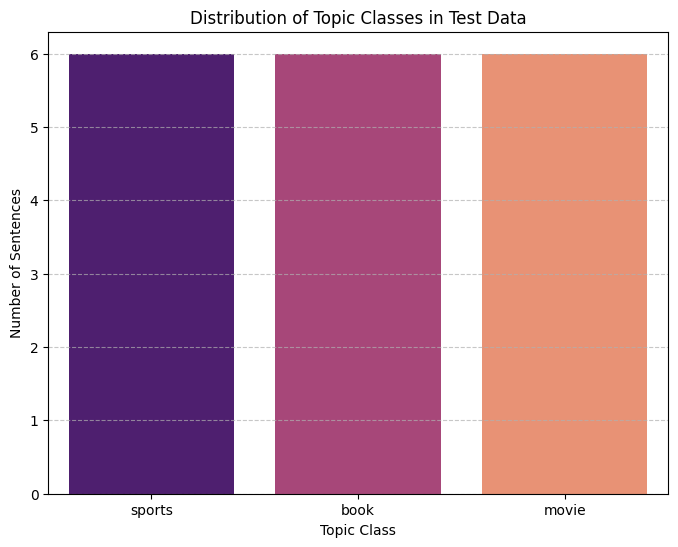


Test Sentence Length Statistics:
count    18.000000
mean     79.722222
std       9.392147
min      57.000000
25%      76.000000
50%      81.000000
75%      85.000000
max      95.000000
Name: sentence_length, dtype: float64


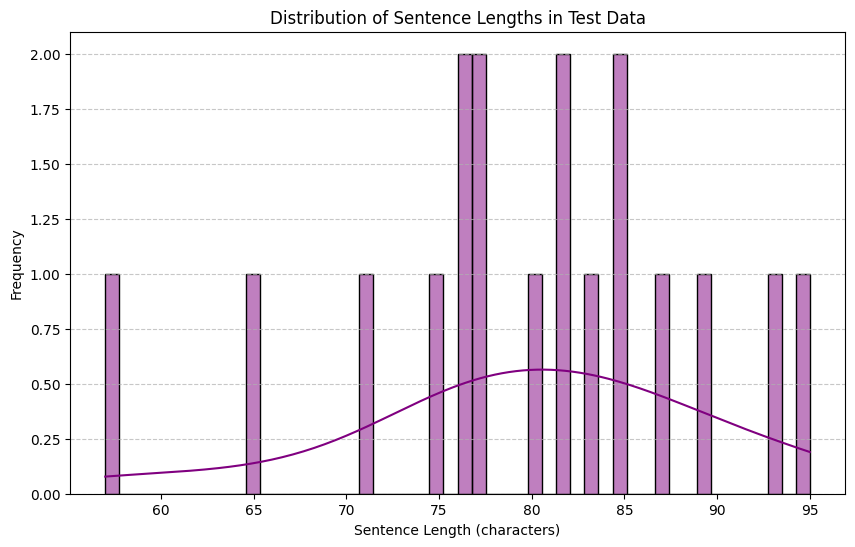

In [ ]:
# Data analysis for test dataset
print("\n" + "="*50)
print("--- Test Dataset Analysis ---")
print("="*50)

print("\nDataFrame Info:")
test_df.info()

print("\nMissing values (NaNs) per column:")
print(test_df.isnull().sum())

print("\nUnique Sentiment Classes in Test Data:")
print(test_df['sentiment'].unique())

print("\nSentiment Class Distribution in Test Data:")
test_sentiment_counts = test_df['sentiment'].value_counts()
print(test_sentiment_counts)

plt.figure(figsize=(8, 6))
sns.barplot(x=test_sentiment_counts.index, y=test_sentiment_counts.values, palette='viridis')
plt.title('Distribution of Sentiment Classes in Test Data')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Sentences')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\nUnique Topic Classes in Test Data:")
print(test_df['topic'].unique())

print("\nTopic Class Distribution in Test Data:")
test_topic_counts = test_df['topic'].value_counts()
print(test_topic_counts)

plt.figure(figsize=(8, 6))
sns.barplot(x=test_topic_counts.index, y=test_topic_counts.values, palette='magma')
plt.title('Distribution of Topic Classes in Test Data')
plt.xlabel('Topic Class')
plt.ylabel('Number of Sentences')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

test_df['sentence_length'] = test_df['sentence'].apply(len)
print("\nTest Sentence Length Statistics:")
print(test_df['sentence_length'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(test_df['sentence_length'], bins=50, kde=True, color='purple')
plt.title('Distribution of Sentence Lengths in Test Data')
plt.xlabel('Sentence Length (characters)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

test_df = test_df.drop(columns=['sentence_length'])

# Sentiment analysis
## Training

In [ ]:
# Sentiment Analysis
print("\n--- Starting Sentiment Analysis ---")

# Define the pipeline for sentiment analysis
sentiment_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1,2))),
    ('clf', LogisticRegression(solver='liblinear', random_state=42, C=1.0, max_iter=1000))
])

# Train the sentiment model
print("Training sentiment model with SST-2 data...")
sentiment_pipeline.fit(sentiment_train_df['processed_sentence'], sentiment_train_df['sentiment'])
print("Sentiment model training complete.")


--- Starting Sentiment Analysis ---
Training sentiment model with SST-2 data...
Sentiment model training complete.


## Evaluation

In [ ]:
# Predict on the test dataset
test_df['predicted_sentiment'] = sentiment_pipeline.predict(test_df['processed_sentence'])

print("\nSentiment Prediction Results (Sample):")
print(test_df[['sentence', 'sentiment', 'predicted_sentiment']].head())

# Evaluate Sentiment Analysis
print("\n--- Evaluating Sentiment Analysis ---")
y_true_sentiment = test_df['sentiment']
y_pred_sentiment = test_df['predicted_sentiment']

print("\nSentiment Classification Report:")
print(classification_report(y_true_sentiment, y_pred_sentiment, zero_division=0))

print("\nSentiment Accuracy:", accuracy_score(y_true_sentiment, y_pred_sentiment))
print("Sentiment F1-Score (macro avg):", f1_score(y_true_sentiment, y_pred_sentiment, average='macro', zero_division=0))
print("Sentiment Precision (macro avg):", precision_score(y_true_sentiment, y_pred_sentiment, average='macro', zero_division=0))
print("Sentiment Recall (macro avg):", recall_score(y_true_sentiment, y_pred_sentiment, average='macro', zero_division=0))

print("\nSentiment Confusion Matrix:")
print(confusion_matrix(y_true_sentiment, y_pred_sentiment, labels=['positive', 'neutral', 'negative']))


Sentiment Prediction Results (Sample):
                                            sentence sentiment  \
0  The stadium was alive with the roar of the cro...  positive   
1  That last-minute goal had me jumping out of my...  positive   
2  I couldn’t put the book down; it swept me into...  positive   
3  The story had its moments, though some parts f...   neutral   
4  I enjoyed the way the timelines shifted, even ...   neutral   

  predicted_sentiment  
0            positive  
1            positive  
2             neutral  
3             neutral  
4            positive  

--- Evaluating Sentiment Analysis ---

Sentiment Classification Report:
              precision    recall  f1-score   support

    negative       0.57      0.67      0.62         6
     neutral       0.67      0.67      0.67         6
    positive       0.60      0.50      0.55         6

    accuracy                           0.61        18
   macro avg       0.61      0.61      0.61        18
weighted avg       0

In [ ]:
test_df.head(20)

,sentence_id,sentence,sentiment,topic,processed_sentence,predicted_sentiment
0,0,The stadium was alive with the roar of the cro...,positive,sports,stadium alive roar crowd incredible win,positive
1,1,That last-minute goal had me jumping out of my...,positive,sports,lastminute goal jumping seat—what unbelievable...,positive
2,2,I couldn’t put the book down; it swept me into...,positive,book,’ put book swept whole new world,neutral
3,3,"The story had its moments, though some parts f...",neutral,book,story moment though part felt like dragged bit,neutral
4,4,"I enjoyed the way the timelines shifted, even ...",neutral,book,enjoyed way timeline shifted even got little c...,positive
5,5,"Every time I watch this movie, I notice someth...",positive,movie,every time watch movie notice something new—it...,negative
6,6,The movie was a wild ride from start to finish...,positive,movie,movie wild ride start finish edge seat entire ...,positive
7,7,"Honestly, the team just fell apart in the seco...",negative,sports,honestly team fell apart second half showed field,negative
8,8,No surprise there—the coach rested a few playe...,neutral,sports,surprise there—the coach rested player given p...,neutral
9,9,"The trailer was decent, giving you a taste wit...",neutral,movie,trailer decent giving taste without spilling s...,neutral


# Topic analysis
## Training

In [ ]:
# Topic Analysis
print("\n--- Starting Topic Analysis ---")

# Define the pipeline for topic analysis
topic_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1,2))), # Increased max_features
    ('clf', LogisticRegression(solver='liblinear', random_state=42, C=1.0, max_iter=1000))
])

# Train the topic model
print("Training topic model with 20 Newsgroups data (subset)...")
topic_pipeline.fit(topic_train_df['processed_sentence'], topic_train_df['topic'])
print("Topic model training complete.")


--- Starting Topic Analysis ---
Training topic model with 20 Newsgroups data (subset)...
Topic model training complete.


## Evaluation

In [ ]:
# Predict on the test dataset
test_df['predicted_topic'] = topic_pipeline.predict(test_df['processed_sentence'])

print("\nSample Topic Predictions on Test Data:")
print(test_df[['sentence', 'topic', 'predicted_topic']].head())


Sample Topic Predictions on Test Data:
                                            sentence   topic predicted_topic
0  The stadium was alive with the roar of the cro...  sports          sports
1  That last-minute goal had me jumping out of my...  sports          sports
2  I couldn’t put the book down; it swept me into...    book            book
3  The story had its moments, though some parts f...    book            book
4  I enjoyed the way the timelines shifted, even ...    book            book


In [ ]:
# Evaluate
print("\n--- Evaluating Topic Analysis ---")
y_true_topic = test_df['topic']
y_pred_topic = test_df['predicted_topic']

print("\nTopic Classification Report:")
print(classification_report(y_true_topic, y_pred_topic, zero_division=0))

print("\nTopic Accuracy:", accuracy_score(y_true_topic, y_pred_topic))
print("Topic F1-Score (macro avg):", f1_score(y_true_topic, y_pred_topic, average='macro', zero_division=0))
print("Topic Precision (macro avg):", precision_score(y_true_topic, y_pred_topic, average='macro', zero_division=0))
print("Topic Recall (macro avg):", recall_score(y_true_topic, y_pred_topic, average='macro', zero_division=0))

print("\nTopic Confusion Matrix (True vs. Predicted):")
print(confusion_matrix(y_true_topic, y_pred_topic, labels=['sports', 'book', 'movie']))


--- Evaluating Topic Analysis ---

Topic Classification Report:
              precision    recall  f1-score   support

        book       0.86      1.00      0.92         6
       movie       1.00      0.50      0.67         6
      sports       0.75      1.00      0.86         6

    accuracy                           0.83        18
   macro avg       0.87      0.83      0.82        18
weighted avg       0.87      0.83      0.82        18


Topic Accuracy: 0.8333333333333334
Topic F1-Score (macro avg): 0.8156288156288157
Topic Precision (macro avg): 0.8690476190476191
Topic Recall (macro avg): 0.8333333333333334

Topic Confusion Matrix (True vs. Predicted):
[[6 0 0]
 [0 6 0]
 [2 1 3]]


In [ ]:
print("\n--- Analysis Complete ---")
print("Final DataFrame with all predictions:")
print(test_df[['sentence_id', 'sentence', 'sentiment', 'predicted_sentiment', 'topic', 'predicted_topic']])


--- Analysis Complete ---
Final DataFrame with all predictions:
    sentence_id                                           sentence sentiment  \
0             0  The stadium was alive with the roar of the cro...  positive   
1             1  That last-minute goal had me jumping out of my...  positive   
2             2  I couldn’t put the book down; it swept me into...  positive   
3             3  The story had its moments, though some parts f...   neutral   
4             4  I enjoyed the way the timelines shifted, even ...   neutral   
5             5  Every time I watch this movie, I notice someth...  positive   
6             6  The movie was a wild ride from start to finish...  positive   
7             7  Honestly, the team just fell apart in the seco...  negative   
8             8  No surprise there—the coach rested a few playe...   neutral   
9             9  The trailer was decent, giving you a taste wit...   neutral   
10           10  I found the main character so annoying